## Replacing the softmax layer with a linear support vector machine. 
## Learning minimizes a margin-based loss instead of the cross-entropy loss.

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
import os
from sklearn.model_selection import train_test_split
from skimage.io import imread
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.utils import to_categorical

2024-04-13 14:59:26.045041: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 14:59:26.045093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 14:59:26.046642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_dataset(base_path):
    images = []
    labels = []
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                image = imread(file_path)
                images.append(image)
                labels.append(folder_name)

    return images, labels

In [3]:
base_path = '/kaggle/input/alzheimer-mri-dataset/Dataset'
images, labels = load_dataset(base_path)

In [4]:
np.random.seed(42)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

In [6]:
print(np.shape(X_train), np.shape(X_test))

(5120, 128, 128) (1280, 128, 128)


In [7]:
# Convert lists to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Reshape the arrays
X_train = X_train.reshape(5120, 128, 128, 1) # Add an additional dimension to represent the single-channel
X_test = X_test.reshape(1280, 128, 128, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

In [8]:
X_train.shape, X_test.shape

((5120, 128, 128, 1), (1280, 128, 128, 1))

In [9]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert integer labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

In [11]:
!pip install efficientnet
import efficientnet.tfkeras as efn

In [12]:
base_model = efn.EfficientNetB3(weights=None, include_top=False, input_shape=(128, 128, 1))

In [13]:
base_model.trainable = True

# add custom top layers
last_output = base_model.output
print(last_output.shape)

(None, 4, 4, 1536)


In [14]:
from tensorflow.keras import layers

In [15]:
x = layers.GlobalAveragePooling2D()(last_output)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(4, activation='linear', use_bias=False, name='svm')(x)

# Configure and compile the model
model = Model(base_model.input, x)

In [16]:
def svm_loss(layer):
    weights = layer.weights[0]
    weights_tf = tf.convert_to_tensor(weights)
    
    def categorical_hinge_loss(y_true, y_pred):
        pos = K.sum(y_true * y_pred, axis=-1)
        neg = K.max((1.0 - y_true) * y_pred, axis=-1)
        hinge_loss = K.mean(K.maximum(0.0, neg - pos + 1), axis=-1)
        regularization_loss = 0.5*(tf.reduce_sum(tf.square(weights_tf)))
        return regularization_loss + 0.4*hinge_loss
    
    return categorical_hinge_loss

In [17]:
metrics = ['accuracy']

optimizer = Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer, loss=svm_loss(model.get_layer('svm')), metrics=metrics)

In [18]:
batch_size = 64
epochs = 20

history = model.fit(X_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/20


I0000 00:00:1713020543.263208    1120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 149s 151ms/step - accuracy: 0.4562 - loss: 4.4248
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.4942 - loss: 4.3198
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.5345 - loss: 4.2480
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.5852 - loss: 4.2043
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.6469 - loss: 4.1858
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.7038 - loss: 4.1353
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.7576 - loss: 4.0867
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.8050 - loss: 4.0482
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.8366 - loss: 4.0249
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.8767 - loss: 3.9939
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.8927 - loss: 3.9751
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/st

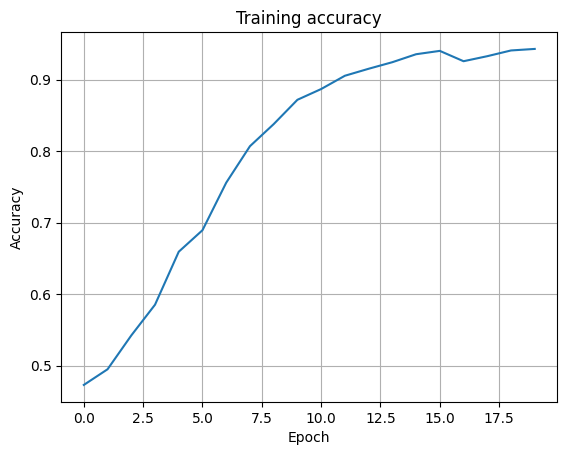

In [19]:
import matplotlib.pyplot as plt


# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['accuracy']

# Get number of epochs
epochs = range(len(loss))


plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.title('Training accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)     # Add grid
plt.show()

In [20]:
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)

# Generate classification report
class_report = classification_report(y_true_labels, y_pred_labels)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

print("Classification Report:")
print(class_report)

print("Confusion Matrix:")
print(conf_matrix)

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.39      0.56       179
           1       0.00      0.00      0.00        13
           2       0.82      0.97      0.89       640
           3       0.82      0.82      0.82       448

    accuracy                           0.83      1280
   macro avg       0.65      0.55      0.57      1280
weighted avg       0.83      0.83      0.81      1280

Confusion Matrix:
[[ 70   0  53  56]
 [  2   0   6   5]
 [  0   0 621  19]
 [  0   0  79 369]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


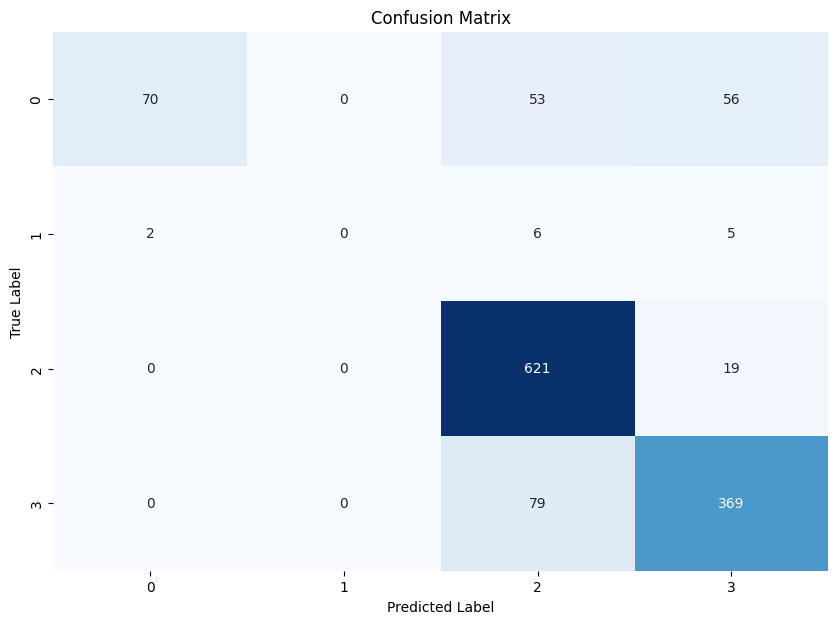

In [21]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Grad-CAM class activation visualization

In [22]:
import matplotlib
import cv2

In [47]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_array, heatmap, cam_path="cam.jpg", alpha=0.4, intensity=0.5):
    # Load the original image
    img = img_array

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Increase intensity of heatmap
    heatmap = np.clip(heatmap * intensity, 0, 255).astype(np.uint8)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]

    # Apply the colormap
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)
    return cam_path
    
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (128,128)


# Remove last layer's softmax
model.layers[-1].activation = None

In [48]:
import matplotlib.cm as cm

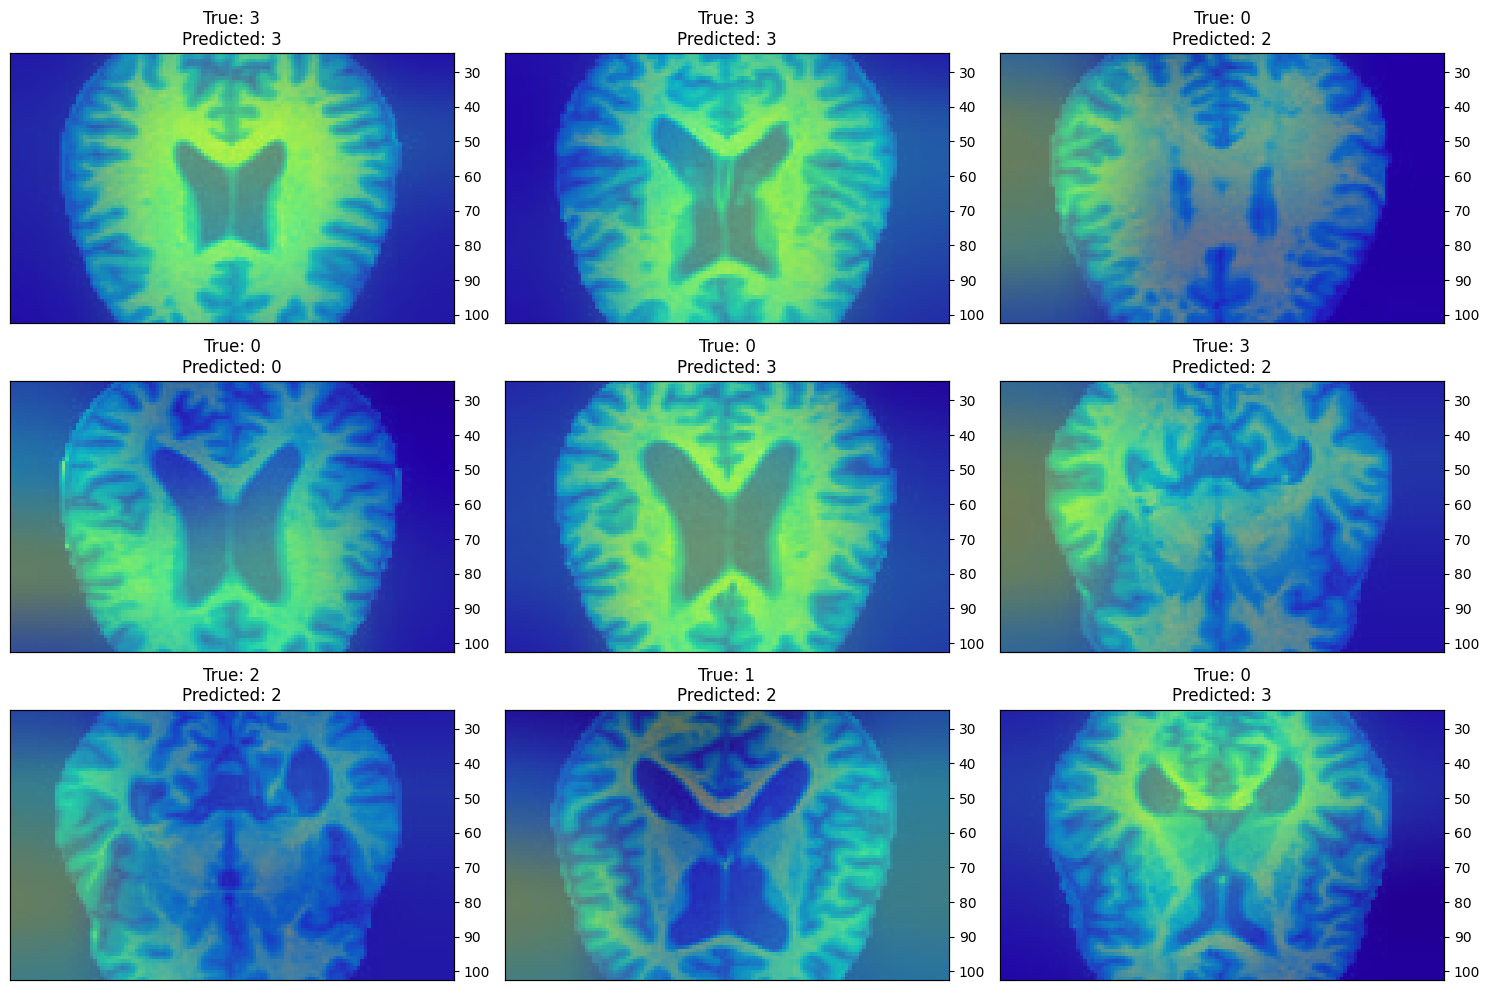

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_array = X_test[i]  # Assuming X_test contains the images
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_array, heatmap)  # Assuming you have a function to save and display GradCAM
    
    # Plot the original image
    ax.imshow(img_array)
    
    # Add title with true and predicted labels
    ax.set_title(f"True: {y_true_labels[i]}\nPredicted: {y_pred_labels[i]}")

    # Plot the GradCAM visualization
    ax_heatmap = ax.twinx()
    ax_heatmap.imshow(plt.imread(cam_path), alpha=0.5)  # Display GradCAM with transparency

plt.tight_layout()
plt.show()